In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib as plt

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
stop_words = set(stopwords.words('english')) 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Load cleaned and preprocessed CSV file as a dataframe.
fp = os.path.join('', 'tweets_sentiment.csv')    # File path
df = pd.read_csv(fp, sep='\t', encoding='utf-8') # Load as dataframe

df.head(2)

,tweet,hashtags,hashtags_number,likes,retweets,sentiment,sentiment_class
0,vanguardsw rt chboursin ai achieve human like ...,human-like skills,2,0,7,0.22,Positive
1,windy interview really groundbreaking can t wr...,interview groundbreaking. head DeepState reali...,6,0,3,0.20,Positive


In [9]:
# New feature columns:: 

# 1. 'pos': collective tweet POS fg. " NN VBP JJ ", str
# 2. One for each POS with value of its occurences in a tweet fg. 3, int

# tweet as a POS string fg. " NN VBP JJ "
def tweet_pos(tweet):
    words = nltk.word_tokenize(tweet) 
    legit_words = [w for w in words if not w in stop_words]
    pos = [w[1] for w in nltk.pos_tag(legit_words)]
    return ' ' + ' '.join(pos) + ' '

# Get all POS (occuring above 30 times) names
def get_valid_pos_names(pos_column):
    all_pos = list(np.concatenate([v[0].split() for v in pos_column.str.split(';\s')]))
    return np.unique([i for i in all_pos if all_pos.count(i)>30])

df['pos'] = df.tweet.apply(tweet_pos)

for pos in get_valid_pos_names(df.pos):
    df[pos] = df.pos.str.count(' {} '.format(pos))

    
print(df.shape)
df.head(2)

(3800, 29)


,tweet,hashtags,hashtags_number,likes,retweets,sentiment,sentiment_class,pos,CC,CD,...,NNS,PRP,RB,RBR,VB,VBD,VBG,VBN,VBP,VBZ
0,vanguardsw rt chboursin ai achieve human like ...,human-like skills,2,0,7,0.22,Positive,NN NN NN VBP VBP NN IN NNS VBP JJ NN VBP VBP ...,0,0,...,1,0,0,0,0,0,0,0,3,0
1,windy interview really groundbreaking can t wr...,interview groundbreaking. head DeepState reali...,6,0,3,0.20,Positive,JJ NN RB VBG NN NN NN IN NN NN NN,0,0,...,0,0,1,0,0,0,1,0,0,0


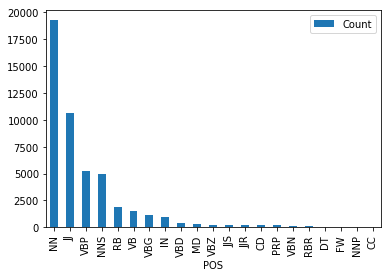

In [10]:
# Explore most occuring
pos_total = sum(df.pos.apply(lambda x: len(x.split())))
words_total = sum(df.tweet.apply(lambda x: len(x.split())))

overview = []
for i, col in enumerate(df.columns):
    if col.isupper():
        cnt = df[col].sum()
        proportion = round(cnt / pos_total, 4) * 100
        overview.append(pd.Series([col, cnt, proportion]))

overview = pd.DataFrame(overview).sort_values(by=[2], ascending=False).reset_index(drop=True)
overview.columns = ['POS', 'Count', 'Percent']

overview.plot.bar('POS','Count')

#### Top occuring parts of speech:
- <b>NN: noun, common, singular or mass</b> fg. uppon whether out inside pro despite on by
- <b>JJ: adjective or numeral, ordinal</b> fg. calamitous first separable ectoplasmic 
- <b>VBP: verb, present tense, not 3rd person singular</b> fg. predominate wrap resort sue twist
- <b>NSS: noun, common, plural</b> fg. averages subjectivists apprehensions muses
- <b>RB: adverb</b> fg. occasionally adventurously professedly stirringly
- <b>VBG: verb, present participle or gerund</b> fg.  stirring focusing angering judging stalling
- <b>IN: preposition or conjunction, subordinating</b> fg. astride among uppon whether out

nltk.help.upenn_tagset('NN')

In [11]:
overview

,POS,Count,Percent
0,NN,19264,31.73
1,JJ,10588,17.44
2,VBP,5191,8.55
3,NNS,4945,8.15
4,RB,1850,3.05
5,VB,1498,2.47
6,VBG,1160,1.91
7,IN,997,1.64
8,VBD,359,0.59
9,MD,302,0.50


In [361]:
linguistic_features = overview.POS.to_list()
top_linguistic_features = ['NN', 'JJ', 'VBP', 'NNS'] # 'RB', 'VBG', 'IN'
tweet_features = ['hashtags_number'] #'likes', 'retweets']
# tweet_features 
features = top_linguistic_features +  tweet_features
label    = 'sentiment' # _class'

X = df.loc[:,features]
y = df.loc[:,label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

LR = LinearRegression(normalize=True).fit(X_train, y_train,)

def remap_sentiment(results):
    remapped = []
    for r in results:
        if r > 0:
            remapped.append(True)
        if r < 0:
            remapped.append(False)
    return remapped

coef = LR.coef_
intercept = LR.intercept_
r_squared_train = round(LR.score(X_train, y_train), 2)
r_squared_test  = round(LR.score(X_test,  y_test), 2)
predictions = LR.predict(X_test)

check = remap_sentiment(y_test)
result = remap_sentiment(predictions)

# Accuracy and Confusion matrix
FP, FN, TP, TN = 0, 0, 0, 0
for prediction in zip(check, result):
    # Binarize float sentiment to Positive/Negative.
    if prediction[0] == True:
        if prediction[0] == prediction[1]:
            TP += 1
        if prediction[0] != prediction[1]:
            FN += 1
    elif prediction[0] == False:
        if prediction[0] == prediction[1]:
            TN += 1
        if prediction[0] != prediction[1]:
            FP += 1
            
print('TP: {}'.format(TP))
print('TN: {}'.format(TN))
print('FP: {}'.format(FP))
print('FN: {}'.format(FN))
print('Accuracy: {}'.format(round((TP+TN)/(TP+TN+FP+FN),3)))
print('R-squared - train: {}\nR-squared - test:  {}\nCoefficient: {}\nIntercept:  {}\nFirst three predictions (of {}): {} ...'.format(r_squared_train, r_squared_test, coef, intercept, len(predictions), predictions[:3]))

TP: 1373
TN: 2
FP: 514
FN: 11
Accuracy: 0.724
R-squared - train: 0.03
R-squared - test:  0.02
Coefficient: [ 0.00193771 -0.01665446  0.0001232   0.00846757  0.0113973 ]
Intercept:  0.07642086512259913
First three predictions (of 1900): [0.12850234 0.04560561 0.11141183] ...


Accuracy - train: 0.71
Accuracy - test:  0.71
First three predictions (of 950): ['Positive' 'Positive' 'Positive'] ...
First three propabilities (of 950): [[0.28356563 0.71643437]
 [0.31979226 0.68020774]
 [0.31881203 0.68118797]] ...


/home/luke/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


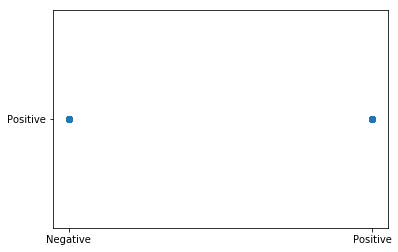

In [462]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Algorithm
import matplotlib.pyplot as plt

# Logistic regression
linguistic_features = overview.POS.to_list()
top_linguistic_features = ['NN', 'JJ', 'VBP', 'NNS'] # 'RB', 'VBG', 'IN'
tweet_features = ['hashtags_number'] #'likes', 'retweets']
# tweet_features 
features = top_linguistic_features +  tweet_features
label    = 'sentiment_class'

X = df.loc[:,features]
y = df.loc[:,label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y)

LGR = LogisticRegression(penalty='l2',
                         C=5, random_state = 0).fit(X_train, y_train)

accuracy_train = round(LGR.score(X_train, y_train), 2)
accuracy_test  = round(LGR.score(X_test,  y_test), 2)
predictions = LGR.predict(X_test)
probabilities = LGR.predict_proba(X_test)

print('Accuracy - train: {}\nAccuracy - test:  {}\nFirst three predictions (of {}): {} ...\nFirst three propabilities (of {}): {} ...'.format(accuracy_train, accuracy_test, len(predictions), predictions[:3], len(probabilities), probabilities[:3]))
plt.scatter(y_test, predictions)
plt.show()

In [464]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

Accuracy - train: 0.71
Accuracy - test:  0.71
First three predictions (of 1900): ['Positive' 'Positive' 'Positive'] ...
First three propabilities (of 1900): [[0.39442231 0.60557769]
 [0.15632184 0.84367816]
 [0.31790744 0.68209256]] ...


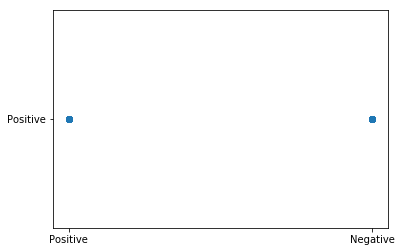

In [581]:
linguistic_features = overview.POS.to_list()
top_linguistic_features = ['NN', 'JJ', 'VBP', 'NNS'] # 'RB', 'VBG', 'IN'
tweet_features = ['hashtags_number'] #'likes', 'retweets']
# tweet_features 
features = top_linguistic_features + tweet_features
label    = 'sentiment_class'

X = df.loc[:,features]
y = df.loc[:,label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

DTC = DecisionTreeClassifier(max_depth=8, min_samples_leaf=400).fit(X_train, y_train)

r_squared_train = round(DTC.score(X_train, y_train), 2)
r_squared_test  = round(DTC.score(X_test,  y_test), 2)
predictions = DTC.predict(X_test)
probabilities = DTC.predict_proba(X_test)

print('Accuracy - train: {}\nAccuracy - test:  {}\nFirst three predictions (of {}): {} ...\nFirst three propabilities (of {}): {} ...'.format(r_squared_train, r_squared_test, len(predictions), predictions[:3], len(probabilities), probabilities[:3]))
plt.scatter(y_test, predictions)
plt.show()